In [1]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(weights="FCN_ResNet101_Weights.DEFAULT").eval()

In [26]:
import torch
import torchvision.transforms as T

In [2]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter

/var/folders/vq/3kk0fzh5509g0jkz5rt3zzsh0000gn/T/ipykernel_59110/1981465829.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [5]:
def load_video(fn):
    import skvideo
    import skvideo.io
    videodata = skvideo.io.vread(fn)
    return videodata

In [6]:
def save_video(videodata,ofn='outvideo.mp4'):
    import skvideo
    import skvideo.io
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})

In [7]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [33]:
def get_seg(net, img, show=True, dev='cpu'):
    
    if not type(img)==PIL.Image.Image:
        img = Image.fromarray(img)
    
    if show: plt.figure(figsize=(15,5))
    
    if show: plt.subplot(1,3,1);plt.imshow(img); plt.axis('off');
    
    
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize((720,1280)), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    #plt.imshow(rgb); plt.axis('off'); plt.show()
    
    seg_resized = Image.fromarray(rgb).resize((512,512),resample=PIL.Image.NEAREST)
    
    #bg = (np.array(seg_resized)==0).sum(axis=-1)==3
    #img_copy = np.array(img).copy()
    #img_copy[:,:,0][bg] = 0
    #img_copy[:,:,1][bg] = 0
    #img_copy[:,:,2][bg] = 0
    #Image.fromarray(img_copy)
    
    if show: plt.subplot(1,3,2);plt.imshow(rgb); plt.axis('off');
    
    if show: plt.subplot(1,3,3);plt.imshow(seg_resized); plt.axis('off');
    
    
    if show: plt.show()
    
    return rgb

In [37]:
fn = 'wall_paint_brush_004.mp4'
video_data = load_video(fn)
video_data.shape

(53, 720, 1280, 3)

In [49]:
fn = 'taking_selfie_014.mp4'
video_data = load_video(fn)
video_seg = np.array([get_seg(fcn,video_data[i,:,:,:],show=False) for i in tqdm(range(video_data.shape[0]))])
save_video(video_seg,fn.replace('.mp4','_seg.mp4'))


100%|███████████████████████████████████████████| 62/62 [05:39<00:00,  5.48s/it]


In [38]:
frame = video_data[1,:,:,:]

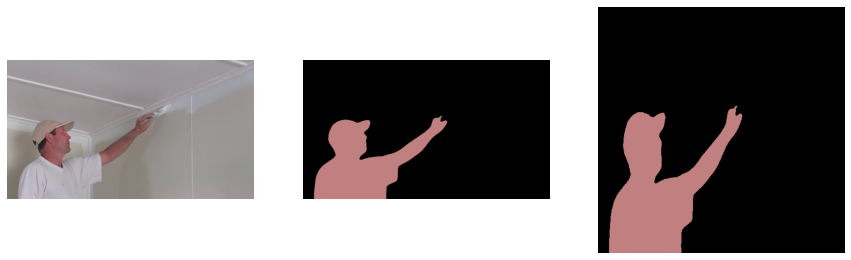

In [39]:
seg = get_seg(fcn,frame)

In [4]:
# def get_bg(net, img, show=True, dev='cpu'):
    
#     if not type(img)==PIL.Image.Image:
#         img = Image.fromarray(img)
    
    
#     if show: plt.figure(figsize=(15,5))
    
#     if show: plt.subplot(1,3,1);plt.imshow(img); plt.axis('off');
    
    
#     # Comment the Resize and CenterCrop for better inference results
#     trf = T.Compose([T.Resize(640), 
#                    #T.CenterCrop(224), 
#                    T.ToTensor(), 
#                    T.Normalize(mean = [0.485, 0.456, 0.406], 
#                                std = [0.229, 0.224, 0.225])])
#     inp = trf(img).unsqueeze(0).to(dev)
#     out = net.to(dev)(inp)['out']
#     om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
#     rgb = decode_segmap(om)
#     #plt.imshow(rgb); plt.axis('off'); plt.show()
    
    
#     seg_resized = Image.fromarray(rgb).resize((512,512),resample=PIL.Image.NEAREST)
#     bg = (np.array(seg_resized)==0).sum(axis=-1)==3
#     img_copy = np.array(img).copy()
#     img_copy[:,:,0][bg] = 0
#     img_copy[:,:,1][bg] = 0
#     img_copy[:,:,2][bg] = 0
#     #Image.fromarray(img_copy)
    
#     if show: plt.subplot(1,3,2);plt.imshow(rgb); plt.axis('off');
    
#     if show: plt.subplot(1,3,3);plt.imshow(img_copy); plt.axis('off');
    
    
#     if show: plt.show()
    
#     return bg